In [1]:
import pickle
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from bisect import bisect_left
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
from quadtreev2 import Point, Node, QTree
from matplotlib import gridspec
from quadtreev2 import find_children
from utils.bandLayers import *
import pickle
import os

In [2]:
device = torch.device('cuda:{}'.format(1))

def eval_metrics_negative(y_pred_in, y_true_in):
    eps=1e-10
    y_pred = torch.clone(y_pred_in)
    y_true = torch.clone(y_true_in)
    if regression:
        y_pred = (y_pred < 5).float()
        y_true = (y_true < 5).float()
        #print(torch.max(y_pred))
    else:
        y_pred = sigmoid(y_pred)
    #y_true = eval_label
    #y_pred = pred_prob 
    true_positive =  torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
    #false_positive = 
    gt_positive = torch.sum(torch.clamp(y_true, 0, 1))
    #gt_negative = 
    pred_positive = torch.sum(torch.round(torch.clamp(y_pred, 0, 1))) 
    
    precision = true_positive / (pred_positive + eps)
    
    recall = true_positive / (gt_positive + eps)
    
    f1_score = 2*precision*recall / (precision + recall + eps)
    
    return precision, recall, f1_score

def shuffle_data(data):
    shuffler = np.random.permutation(len(label))
    data_shuffled = data[shuffler]
    return data_shuffled
def evaluate(transformer, evl_input_seq, evl_output_seq, batch_downsample,
                              evl_input_time, evl_input_space,evl_output_time, 
                              evl_output_space,evl_src_mask,evl_trg_mask,evl_label,
             BATCH_SIZE,lr_criterion):

    num_batch = math.ceil(evl_input_seq.shape[0] / BATCH_SIZE)

    #eval_data, eval_label = shuffle_data_label(eval_data, eval_label)

    lr_pred_prob = np.zeros(evl_input_seq.shape[0])
    
    total_loss = 0
    prediction = []
    pred_uq = []
    
    weight_list = np.zeros((len(evl_input_seq),  1, 45  ))
    with torch.no_grad():
        for k in range(num_batch):
            s_idx = k * BATCH_SIZE

            e_idx = min(evl_input_seq.shape[0], s_idx + BATCH_SIZE)
            #feat_cut = torch.clone(eval_data[s_idx:e_idx])

            label_cut = evl_label[s_idx:e_idx]

            transformer = transformer.eval()
            # evl_downsample_sub = []
            # for mat in evl_downsample[s_idx:e_idx]:
            #     evl_downsample_sub.append(sparse.csr_matrix.todense(mat))
            # evl_downsample_sub = torch.from_numpy(np.array(evl_downsample_sub)).float().to(device)

            lr_prob, weights, uncertainty = transformer(evl_input_seq[s_idx:e_idx], evl_output_seq[s_idx:e_idx], batch_downsample[k],
                              evl_input_time[s_idx:e_idx], evl_input_space[s_idx:e_idx],evl_output_time[s_idx:e_idx], 
                              evl_output_space[s_idx:e_idx],evl_src_mask[s_idx:e_idx],evl_trg_mask[s_idx:e_idx])
            weight_list[s_idx:e_idx,:] = weights.cpu().numpy()
            lr_loss = lr_criterion(lr_prob.squeeze(), 
                                   label_cut)

            total_loss += lr_loss
            if k ==0:
                prediction=lr_prob.cpu().detach().numpy()
                pred_uq = uncertainty.cpu().detach().numpy()
            else:
                prediction=np.concatenate((prediction, lr_prob.cpu().detach().numpy()), axis = 0)
                pred_uq = np.concatenate((pred_uq, uncertainty.cpu().detach().numpy()), axis = 0)
                
    precision, recall, f1_score = eval_metrics(torch.from_numpy(prediction).squeeze().to(device), evl_label)
    precision_neg, recall_neg, f1_score_neg = eval_metrics_negative(torch.from_numpy(prediction).squeeze().to(device), evl_label)
    
    validation_loss =  total_loss.cpu().detach().numpy() / evl_input_seq.shape[0]
    return validation_loss, np.array(prediction),np.array(pred_uq), weight_list, precision, recall, f1_score, precision_neg, recall_neg, f1_score_neg

In [3]:
TIME_WINDOW = 300
longest_window = 400

regression  = True
number_selection = 20 
BATCH_SIZE = 512
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return len(myList) - 1
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return pos
    else:
        return pos - 1
def calCord(latarray, longarray):
    xaxis = []
    yaxis = []
    for i in range(latarray.shape[0]): 
        lat = latarray[i]
        long = longarray[i]
        
        latMid = (lat+minlat )/2.0


        m_per_deg_lat = (111132.954 - 559.822 * math.cos( 2.0 * latMid ) + 1.175 * math.cos( 4.0 * latMid)) / 1e5
        m_per_deg_lon = ((3.14159265359/180 ) * 6367449 * math.cos ( latMid ))/1e5

        deltaLat = math.fabs(lat - minlat)
        deltaLon = math.fabs(long - minlong)
        
        xaxis.append(deltaLat * m_per_deg_lat)
        yaxis.append(deltaLon * m_per_deg_lon )
    
    return np.array(xaxis), np.array(yaxis) 

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def DepthNorm(name, par, depth):
    keys = np.load(data_path + name + '_keys.npy')
    means = np.load(data_path + name+ '_means.npy')
    stds = np.load(data_path + name + '_stds.npy')
    
    feature_norm = []
    for i in range(len(par)):
        depth_val = -depth[i]
        if not np.isnan(depth_val):
            indices = take_closest(keys, depth_val)
            #print(indices)
        else:
            indices = take_closest(keys, -1)
        #print(len(indices))
        #print(indices)
        #assert len(indices) >= 1
                                                    
        mean_val = means[indices]
        std_val = stds[indices]
        new_val = (par[i] - mean_val) / (std_val + 1e-3)
        feature_norm.append(new_val)
        
    
    return feature_norm

def findLargestIndex(time, specific_index):
    index = specific_index - 1
    while True:
        if index < 0 or time[index] < time[specific_index]:
            break
        else:
            index = index - 1
    return index

def NormalizeDataMultiDim(data):
    for i in range(data.shape[1]):
        if not np.isnan ((np.max(data[:, i]) - np.min(data[:,i]))):
            data[:,i] = (data[:,i] - np.min(data[:,i])) / (np.max(data[:, i]) - np.min(data[:,i]))
    return data

def shuffle_data_label(data, label):
    shuffler = np.random.permutation(len(label))
    data_shuffled = data[shuffler]
    label_shuffled = label[shuffler]
    return data_shuffled, label_shuffled

def prepareDataset(features_st,label, TIME_WINDOW): 
    time = features_st[:, -1]
    features_concat = []
    label_concat = []
    for i in range(features_st.shape[0]):
        idx_end = findLargestIndex(time, i)
        idx_start = idx_end + 1  - TIME_WINDOW
        if idx_start > 0:
            features_neigh = features_st[idx_start:idx_end + 1, :]
            features_i = features_st[i,:]
            features_i = np.expand_dims(features_i, axis = 0)
            #features_i = np.expand_dims(features_i, axis = 0)
            #features_neigh = np.expand_dims(features_neigh, axis = 0)
            features_concat_i = np.concatenate((features_i, features_neigh), axis = 0)
            features_concat.append(features_concat_i)
            label_concat.append(label[i])
    return np.array(features_concat),np.array(label_concat)

home_path = '/home/whe2/STGNN/experiment/'
with open(home_path + 'data/paired_dataset.pkl', 'rb') as f:
    paired_data = pickle.load(f)
file_errors_location = home_path + 'data/PinellasMonroeCoKareniabrevis 2010-2020.06.12.xlsx'
df = pd.read_excel(file_errors_location)
for name in ['par', 'chlor_a', 'Rrs_443','Rrs_469','Rrs_488', 'Kd_490', 'nflh']:
    df[name] = 0
df = df.sort_values('Sample Date')
df_unix_sec = (pd.to_datetime(df['Sample Date'])).astype(int)/10**9
df_unix_sec = df_unix_sec.to_numpy()
#df_unix = (df_unix_sec - df_unix_sec[0])/(df_unix_sec[3] - df_unix_sec[0])
#df['Sample Date'] = df_unix
#da_new = df[['Sample Date', 'Sample Depth (m)', 'Latitude','Longitude','Karenia brevis abundance (cells/L)' ]]
#da_new = da_new.to_numpy()

time_df = df_unix_sec
lat_df = df['Latitude']
long_df = df['Longitude']
concen_df = df['Karenia brevis abundance (cells/L)']

length = len(time_df)
features_df = df['par'].to_numpy().reshape(length,1)
for name in [ 'chlor_a', 'Rrs_443','Rrs_469','Rrs_488', 'Kd_490', 'nflh','Karenia brevis abundance (cells/L)']:
    features_df = np.concatenate((features_df, df[name].to_numpy().reshape(length,1)),axis = 1)



paired_data = paired_data.sort_values('Sample Date')
depth = paired_data['Sample Depth']
time_paired = paired_data['Sample Date']
time_paired = (pd.to_datetime(time_paired)).astype(int)/10**9
time_paired = time_paired.to_numpy() 



lat_paired = paired_data['Latitude']
long_paired = paired_data['Longitude']
lat_paired = lat_paired.to_numpy()
long_paired = long_paired.to_numpy()
maxlat_paired = np.max(lat_paired)
minlat_paired = np.min(lat_paired)
maxlong_paired = np.max(long_paired)
minlong_paired = np.min(long_paired)


par = paired_data['par']
par = par.to_numpy()
chlor_a = paired_data['chlor_a']
chlor_a = chlor_a.to_numpy()
Rrs_443 = paired_data['Rrs_443']
Rrs_443 = Rrs_443.to_numpy()
Rrs_469 = paired_data['Rrs_469']
Rrs_469 = Rrs_469.to_numpy()
Rrs_488 = paired_data['Rrs_488']
Rrs_488 = Rrs_488.to_numpy()
Kd_490 = paired_data['Kd_490']
Kd_490 = Kd_490.to_numpy()
nflh = paired_data['nflh']
nflh = nflh.to_numpy()

data_path = '/home/whe2/STGNN/experiment/data/depth_stats/'
par_norm = DepthNorm('par',par,depth)
chlor_a_norm = DepthNorm('chlor_a', chlor_a, depth)
Rrs_443_norm = DepthNorm('Rrs_443', Rrs_443, depth)
Rrs_469_norm = DepthNorm('Rrs_469', Rrs_469, depth)
Rrs_488_norm = DepthNorm('Rrs_488', Rrs_488, depth)
Kd_490_norm = DepthNorm('Kd_490', Kd_490, depth)
nflh_norm = DepthNorm('nflh', nflh, depth)

concen_paired = paired_data['Red Tide Concentration']

features_paired = np.stack((par_norm, chlor_a_norm, Rrs_443_norm,Rrs_469_norm,Rrs_488_norm, Kd_490_norm, nflh_norm,concen_paired), axis = 1) 
#features = NormalizeDataMultiDim(features)
#features = np.stack((par, chlor_a, Rrs_443,Rrs_469,Rrs_488, Kd_490, nflh), axis = 1) 

time = np.concatenate((time_df, time_paired), axis = 0)
lat = np.concatenate((lat_df, lat_paired), axis = 0)
long = np.concatenate((long_df, long_paired), axis = 0)
features = np.concatenate((features_df, features_paired), axis = 0)
data_array = np.stack((time, lat, long),axis = 1) 
data_array = np.concatenate((data_array,features), axis = 1)
ind = np.argsort( data_array[:,0] )
data_array = data_array[ind]

time = data_array[:, 0]
time = (time  -  time[0]) / (time[3] - time[0])

lat = data_array[:,1]
long = data_array[:, 2]
features = data_array[:,3:]

concen = np.copy(features[:, -1])
features[:, -1] = np.log(concen + 1)
#concen_mean= np.mean(concen)
#concen_std = np.std(concen)
#concen = (concen - concen_mean) / concen_std

label = np.copy(concen)


if regression:
    label = np.log10(label+1)
    #label = label/np.max(label)
else:
    label = (label > 1e5)
    label = label.astype('uint8')



minlat = np.min(lat)
minlong = np.min(long)
xaxis, yaxis = calCord(np.copy(lat), np.copy(long))
locations = np.stack((xaxis, yaxis), axis = 1)
locations_latlong =  np.stack((lat, long), axis = 1)


def RemoveNan(features, time, locations, locations_latlong, label,concen):
    features_new = []
    time_new = []
    locations_new = []
    locations_latlong_new = []
    label_new = []
    concen_new = []
    
    for i in range(features.shape[0]):
        #flag = 1
        for j in range(features.shape[1]):
            if np.isnan(features[i,j]):
                break;
            if (j == features.shape[1] - 1):
                features_new.append(features[i,:])
                time_new.append(time[i])
                locations_new.append(locations[i,:])
                locations_latlong_new.append(locations_latlong[i,:])
                label_new.append(label[i])
                concen_new.append(concen[i])
    return np.array(features_new), np.array(time_new), np.array(locations_new),np.array(locations_latlong_new), np.array(label_new), np.array(concen)

features, time, locations, locations_latlong, label,concen = RemoveNan(features, time, locations,locations_latlong, label,concen)  

time = time.reshape(len(time), 1)
locations_latlong =  locations_latlong / 10.0
features_st = np.concatenate((features, locations_latlong, time), axis = 1) # -1 time, -2 and -3 locations, -4 concen

features_data, label_data = prepareDataset(features_st, label, TIME_WINDOW)


#train_data, train_label = data_augumentation(train_data, train_label,aug_times = 10)
    
#time = NormalizeData(time)
#locations = NormalizeDataMultiDim(locations)


In [4]:
long = features_st[:,-2]
lat = features_st[:,-3]
lat_min,lat_max = np.min(lat), np.max(lat) 
long_min, long_max = np.min(long), np.max(long)

#longest_window = 800
#TIME_WINDOW = longest_window - 1
#features_data, label_data,mask,sample_size = prepareDataset(features_st, label, TIME_WINDOW,longest_window)
#features_data, label_data = prepareDataset(features_st, label, TIME_WINDOW)

In [5]:
down_mat = []
for i in range(features_data.shape[0]):
    downsample_location = '/blue/zhe.jiang/whe2/band2/300v2/sparse_downsample/' + str(i) + 'downsample_mat.npz'
    down_mat.append(sparse.load_npz(downsample_location))
    

In [6]:
homepath = '/blue/zhe.jiang/whe2/band2/300v2/'
if not os.path.exists(homepath):
    os.mkdir(homepath)

path = homepath +  'list_mask/'
if not os.path.exists(path):
    os.mkdir(path)
loc = homepath +  'list_mask/'  + 'mask_mat.pickle'
with open(loc, 'rb') as handle:
    mask_mat = pickle.load(handle)

In [7]:
train_instance = int(np.shape(features_data)[0]*0.7)
val_instance = int(np.shape(features_data)[0]*0.8)

train_features_data = features_data[:train_instance]
train_label = label_data[:train_instance]

train_mask = mask_mat[:train_instance]
train_downsample = down_mat[:train_instance]

val_features_data = features_data[train_instance:val_instance]
val_label = label_data[train_instance:val_instance]
val_mask = mask_mat[train_instance:val_instance]
val_down_mat = down_mat[train_instance:val_instance]

test_features_data = features_data[val_instance:]
test_label = label_data[val_instance:]
test_mask = mask_mat[val_instance:]
test_down_mat = down_mat[val_instance:]



In [8]:
def data_augumentation(train_data, train_label,train_mask,train_down_mat,aug_times = 10):
    new_train_data = []
    new_train_label = []
    new_train_mask = []
    new_train_down_mat = []
    
    for i in range(len(train_label)):
        if(train_label[i]>=5):
            new_train_data.extend([train_data[i] for j in range(aug_times)])
            new_train_label.extend([train_label[i] for j in range(aug_times)])
            new_train_mask.extend([train_mask[i] for j in range(aug_times)])
            new_train_down_mat.extend([train_down_mat[i] for j in range(aug_times)])
    
    new_train_data = np.array(new_train_data)
    new_train_label = np.array(new_train_label)
    #new_train_mask = np.array(new_train_mask)
    new_train_down_mat = np.array(new_train_down_mat)
    
    train_data = np.concatenate((train_data,new_train_data), axis = 0)
    train_label = np.concatenate((train_label, new_train_label), axis = 0)
    train_mask = train_mask + new_train_mask #np.concatenate((train_mask,new_train_mask), axis = 0)
    train_down_mat = np.concatenate((train_down_mat,new_train_down_mat), axis = 0)
    
    return train_data, train_label,train_mask,train_down_mat


In [9]:
train_features_data, train_label,train_mask,train_downsample = data_augumentation(train_features_data, train_label,train_mask,train_downsample, aug_times = 10)

Preprocess the input data.

In [10]:


torch.set_default_dtype(torch.float32)



shape = train_features_data.shape
train_new_features_data = torch.from_numpy(train_features_data).to(dtype=torch.float32, device= device)

shape = train_features_data.shape
train_input_seq = torch.from_numpy(train_features_data[:,:,:8]).to(dtype=torch.float32, device= device)
train_output_seq = torch.from_numpy(train_features_data[:,0,:8][:,np.newaxis,:]).to(dtype=torch.float32, device= device)

train_input_time = torch.from_numpy(train_features_data[:,:,-1]).to(dtype=torch.float32, device= device)

train_input_space = torch.from_numpy(train_features_data[:,:,-3:-1]).to(dtype=torch.float32, device= device)
train_output_time = torch.from_numpy(train_features_data[:,0,-1][:,np.newaxis]).to(dtype=torch.float32, device= device)
train_output_space = torch.from_numpy(train_features_data[:,0,-3:-1][:,np.newaxis,:]).to(dtype=torch.float32, device= device)

train_label = torch.from_numpy(train_label).to(dtype=torch.float32, device= device)

In [11]:


shape = val_features_data.shape
val_input_seq = torch.from_numpy(val_features_data[:,:,:8]).to(dtype=torch.float32, device= device)
val_output_seq = torch.from_numpy(val_features_data[:,0,:8][:,np.newaxis,:]).to(dtype=torch.float32, device= device)

val_input_time = torch.from_numpy(val_features_data[:,:,-1]).to(dtype=torch.float32, device= device)

val_input_space = torch.from_numpy(val_features_data[:,:,-3:-1]).to(dtype=torch.float32, device= device)
val_output_time = torch.from_numpy(val_features_data[:,0,-1][:,np.newaxis]).to(dtype=torch.float32, device= device)
val_output_space = torch.from_numpy(val_features_data[:,0,-3:-1][:,np.newaxis,:]).to(dtype=torch.float32, device= device)

val_label = torch.from_numpy(val_label).to(dtype=torch.float32, device= device)

In [12]:


shape = test_features_data.shape
test_input_seq = torch.from_numpy(test_features_data[:,:,:8]).to(dtype=torch.float32, device= device)
test_output_seq = torch.from_numpy(test_features_data[:,0,:8][:,np.newaxis,:]).to(dtype=torch.float32, device= device)

test_input_time = torch.from_numpy(test_features_data[:,:,-1]).to(dtype=torch.float32, device= device)

test_input_space = torch.from_numpy(test_features_data[:,:,-3:-1]).to(dtype=torch.float32, device= device)
test_output_time = torch.from_numpy(test_features_data[:,0,-1][:,np.newaxis]).to(dtype=torch.float32, device= device)
test_output_space = torch.from_numpy(test_features_data[:,0,-3:-1][:,np.newaxis,:]).to(dtype=torch.float32, device= device)

test_label = torch.from_numpy(test_label).to(dtype=torch.float32, device= device)

In [13]:

val_input_seq[:,0,-1] = 0
val_output_seq[:,0,-1] = 0
test_input_seq[:,0,-1] = 0
test_output_seq[:,0,-1] = 0

Transformer config

In [14]:

opt = dict()
opt['src_vocab_size'] = 8
opt['trg_vocab_size'] = 8
opt['src_pad_idx'] = -10
opt['trg_pad_idx'] = -10
opt['embed_size'] = 128
opt['num_layers'] = 1
opt['forward_expansion'] = 1
opt['heads'] = 1
opt['dropout'] = 0.2
opt['device'] = device
opt['max_length'] = 10

initialize transformer instance, and set up training loss, optimier, scheduler

In [15]:
transformer = Transformer(
    src_vocab_size = opt['src_vocab_size'],
    trg_vocab_size = opt['trg_vocab_size'],
    src_pad_idx=opt['src_pad_idx'],
    trg_pad_idx=opt['trg_pad_idx'],
    embed_size = opt['embed_size'],
    num_layers=opt['num_layers'],
    forward_expansion=opt['forward_expansion'],
    heads=opt['heads'],
    dropout=opt['dropout'],
    device=opt['device'],
    max_length = opt['max_length']).to(opt['device'])

LEARNING_RATE = 5e-4
regression = True
if regression:
    lr_criterion = torch.nn.MSELoss()
else:
    lr_criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)

lr_optimizer = torch.optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09, lr=LEARNING_RATE, weight_decay=5e-2)
scheduler = optim.lr_scheduler.StepLR(lr_optimizer, step_size=5, gamma=0.9)



8 128


In [16]:

train_src_mask = torch.IntTensor(train_mask).to(device) #torch.from_numpy(np.random.rand(32, 100, 100)).float().to(device)

train_trg_mask = torch.IntTensor([[train_mask[i][0]] for i in range(len(train_mask))]).to(device) #torch.from_numpy(train_mask[:,0,:][:,np.newaxis,:]).to(device)#torch.from_numpy(np.random.rand(32, 1, 100)).float().to(device)

val_downsample = val_down_mat #torch.from_numpy(np.random.rand(32, 100,100)).float().to(device)
val_src_mask = torch.IntTensor(val_mask).to(device) #torch.from_numpy(val_mask).to(device) #torch.from_numpy(np.random.rand(32, 100, 100)).float().to(device)
val_trg_mask = torch.IntTensor([[val_mask[i][0]] for i in range(len(val_mask))]).to(device)#train_mask[:,0].to(device) #torch.from_numpy(val_mask[:,0,:][:,np.newaxis,:]).to(device)#torch.from_numpy(np.random.rand(32, 1, 100)).float().to(device)

test_downsample = test_down_mat #torch.from_numpy(np.random.rand(32, 100,100)).float().to(device)
test_src_mask = torch.IntTensor(test_mask).to(device) #torch.from_numpy(np.random.rand(32, 100, 100)).float().to(device)
test_trg_mask = torch.IntTensor([[test_mask[i][0]] for i in range(len(test_mask))]).to(device)#torch.from_numpy(np.random.rand(32, 1, 100)).float().to(device)


In [17]:
val_instance = val_input_seq.shape[0]
#BATCH_SIZE = 32
val_num_batch = math.ceil(val_input_seq.shape[0] / BATCH_SIZE)

batch_val_downsample = []

for k in range(val_num_batch):
    s_idx = k * BATCH_SIZE

    e_idx = min(val_instance, s_idx + BATCH_SIZE)

    new_row = []
    new_col = []
    new_data = []
    i  = 0
    for val_downsample_sub in val_downsample[s_idx:e_idx]:
        val_downsample_sub = val_downsample_sub.tocoo()
        new_row = np.concatenate((new_row,longest_window*i + val_downsample_sub.row), axis = 0)
        new_col = np.concatenate((new_col,(TIME_WINDOW+1)*i + val_downsample_sub.col), axis = 0)
        new_data = np.concatenate((new_data, val_downsample_sub.data), axis=0)
        i = i + 1
    indices = torch.cat((torch.tensor(new_row[np.newaxis,:], dtype = torch.int), torch.tensor(new_col[np.newaxis,:],  dtype = torch.int)), axis = 0)
    values = torch.tensor(new_data)
    batch_val_downsample.append(torch.sparse_coo_tensor(indices, values, [longest_window*(i), (TIME_WINDOW+1)*(i)],
                                                        dtype = torch.float32, device=device))
            

In [18]:
test_instance = test_input_seq.shape[0]
#BATCH_SIZE = 32
test_num_batch = math.ceil(test_input_seq.shape[0] / BATCH_SIZE)

batch_test_downsample = []

for k in range(test_num_batch):
    s_idx = k * BATCH_SIZE

    e_idx = min(test_instance, s_idx + BATCH_SIZE)

    new_row = []
    new_col = []
    new_data = []
    i  = 0
    for test_downsample_sub in test_downsample[s_idx:e_idx]:
        test_downsample_sub = test_downsample_sub.tocoo()
        new_row = np.concatenate((new_row,longest_window*i + test_downsample_sub.row), axis = 0)
        new_col = np.concatenate((new_col,(TIME_WINDOW+1)*i + test_downsample_sub.col), axis = 0)
        new_data = np.concatenate((new_data, test_downsample_sub.data), axis=0)
        i = i + 1
    indices = torch.cat((torch.tensor(new_row[np.newaxis,:], dtype = torch.int), torch.tensor(new_col[np.newaxis,:],  dtype = torch.int)), axis = 0)
    values = torch.tensor(new_data)
    batch_test_downsample.append(torch.sparse_coo_tensor(indices, values, [longest_window*(i), (TIME_WINDOW+1)*(i)],
                                                        dtype = torch.float32, device=device))
            

In [ ]:
path = "trained_model/28/tgan_space_iter_0_0.44.pt"
#torch.save(tgan.state_dict(), path)
transformer = Transformer(
    src_vocab_size = opt['src_vocab_size'],
    trg_vocab_size = opt['trg_vocab_size'],
    src_pad_idx=opt['src_pad_idx'],
    trg_pad_idx=opt['trg_pad_idx'],
    embed_size = opt['embed_size'],
    num_layers=opt['num_layers'],
    forward_expansion=opt['forward_expansion'],
    heads=opt['heads'],
    dropout=opt['dropout'],
    device=opt['device'],
    max_length = opt['max_length']).to(opt['device'])
transformer = transformer.to(device)
transformer.load_state_dict(torch.load(path))

evaluation_loss,prediction,pred_uq, weight, precision, recall, f1_score,precision_neg, recall_neg, f1_score_neg = evaluate(transformer, test_input_seq, test_output_seq, batch_test_downsample,
                              test_input_time, test_input_space,test_output_time, 
                              test_output_space,test_src_mask,test_trg_mask,test_label,
             BATCH_SIZE,lr_criterion)

In [28]:
prediction = pred_e
label = label_e

positive_index = np.where(label>5)[0]
negative_index = np.where(label<5)[0]
mse = np.square(prediction - label)
positive_loss = np.mean(mse[positive_index])
negative_loss = np.mean(mse[negative_index])

sample :  9002 test label tensor(3.9701, device='cuda:1')
sample :  9003 test label tensor(3.4262, device='cuda:1')
sample :  9005 test label tensor(3.0004, device='cuda:1')
sample :  9007 test label tensor(2.5237, device='cuda:1')
sample :  9010 test label tensor(3.1252, device='cuda:1')
sample :  9011 test label tensor(3.9701, device='cuda:1')
sample :  9012 test label tensor(3.9379, device='cuda:1')
sample :  9013 test label tensor(3.8017, device='cuda:1')
sample :  9016 test label tensor(3.9031, device='cuda:1')
sample :  9018 test label tensor(3.0004, device='cuda:1')
sample :  9022 test label tensor(3.9543, device='cuda:1')
sample :  9023 test label tensor(2.5237, device='cuda:1')
sample :  9024 test label tensor(0., device='cuda:1')
sample :  9030 test label tensor(2.5237, device='cuda:1')
sample :  9031 test label tensor(0., device='cuda:1')
sample :  9037 test label tensor(0., device='cuda:1')
sample :  9038 test label tensor(0., device='cuda:1')
sample :  9041 test label tens

/scratch/local/55797530/ipykernel_904/1098912118.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 8))


sample :  9178 test label tensor(3.4262, device='cuda:1')
sample :  9180 test label tensor(4.8939, device='cuda:1')
sample :  9182 test label tensor(3.4773, device='cuda:1')
sample :  9187 test label tensor(4.9559, device='cuda:1')
sample :  9191 test label tensor(3.8240, device='cuda:1')
sample :  9196 test label tensor(4.5798, device='cuda:1')
sample :  9202 test label tensor(4.5798, device='cuda:1')
sample :  9203 test label tensor(0., device='cuda:1')
sample :  9204 test label tensor(0., device='cuda:1')
sample :  9206 test label tensor(4.9723, device='cuda:1')
sample :  9208 test label tensor(0., device='cuda:1')
sample :  9209 test label tensor(0., device='cuda:1')
sample :  9210 test label tensor(0., device='cuda:1')


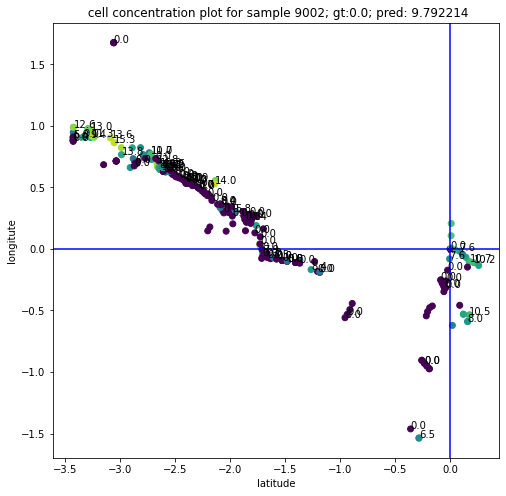

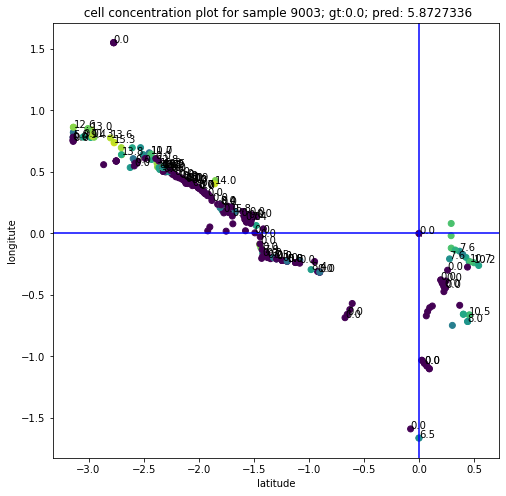

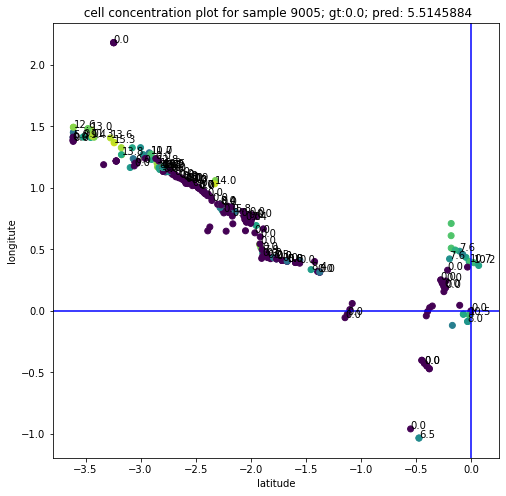

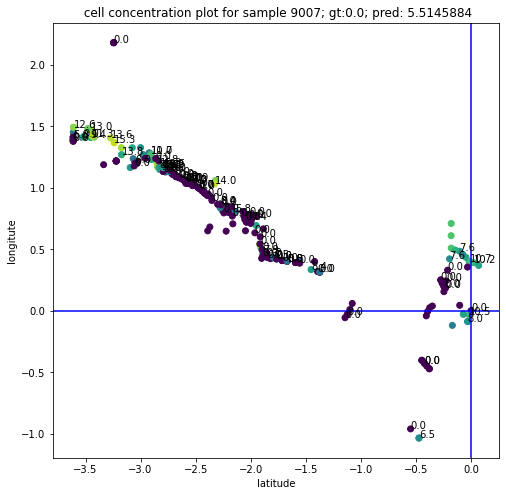

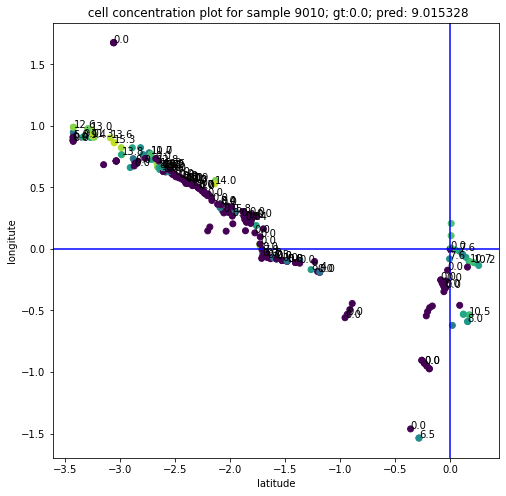

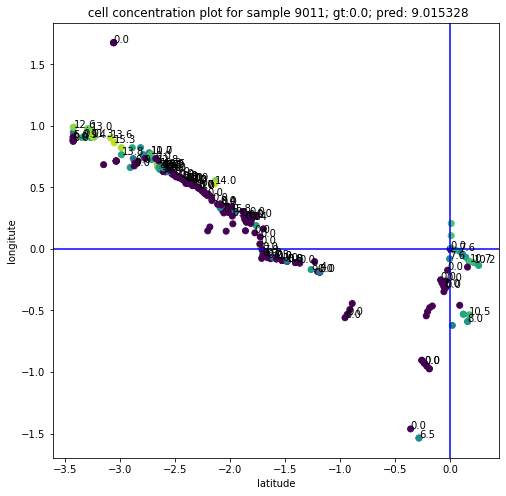

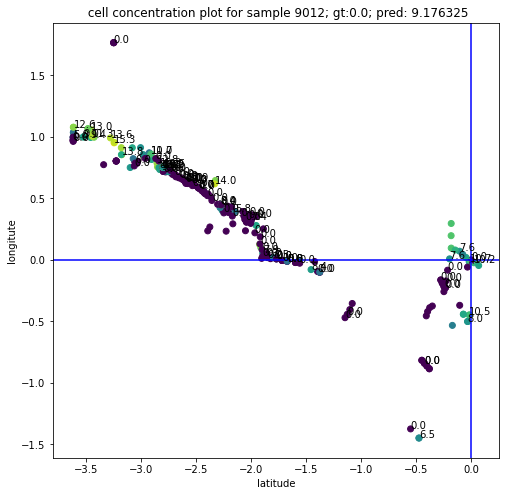

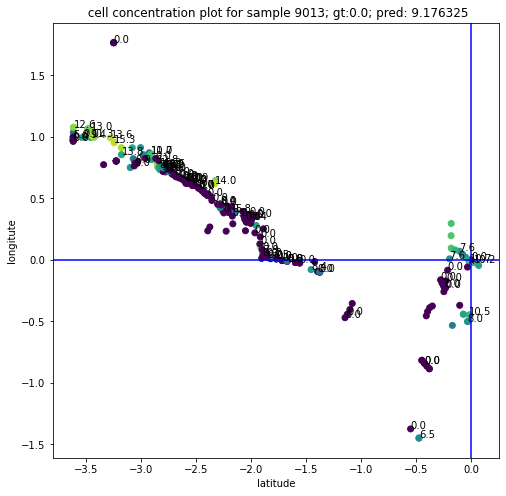

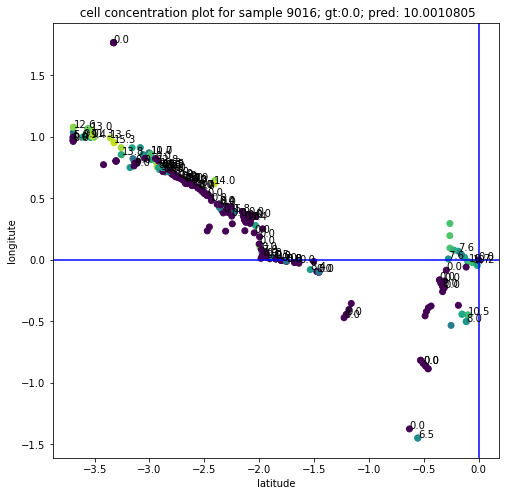

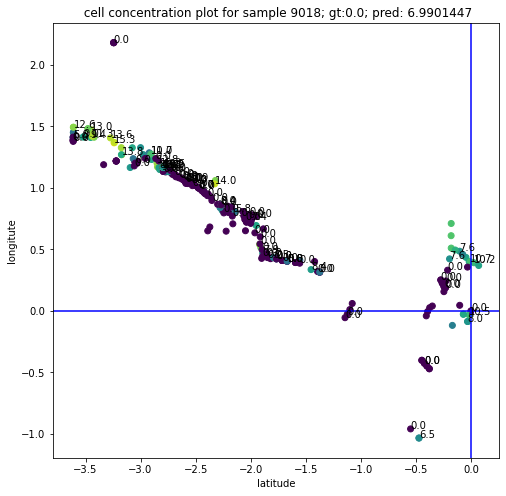

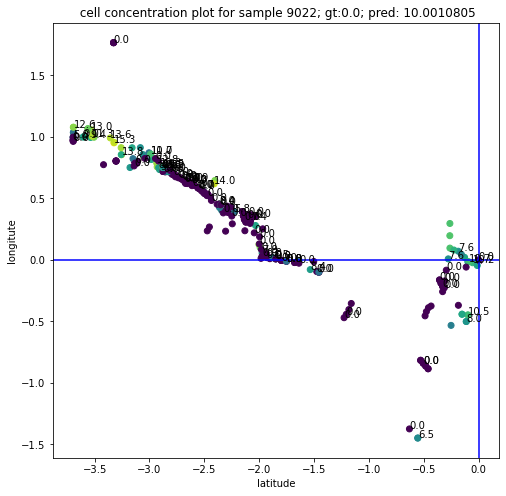

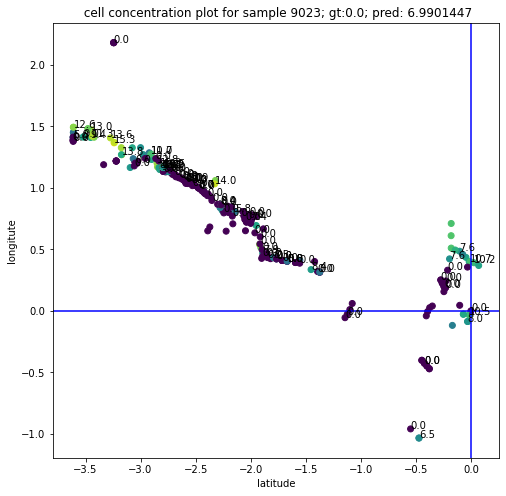

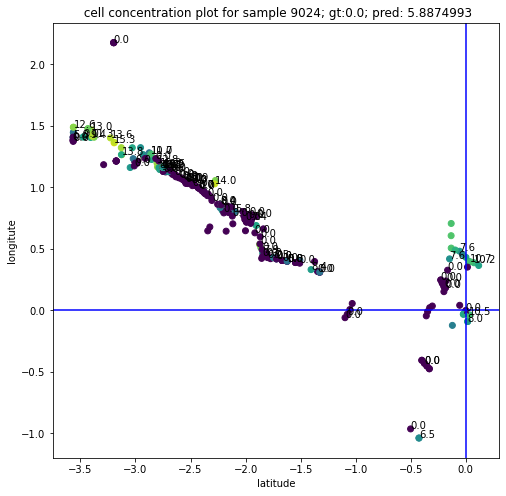

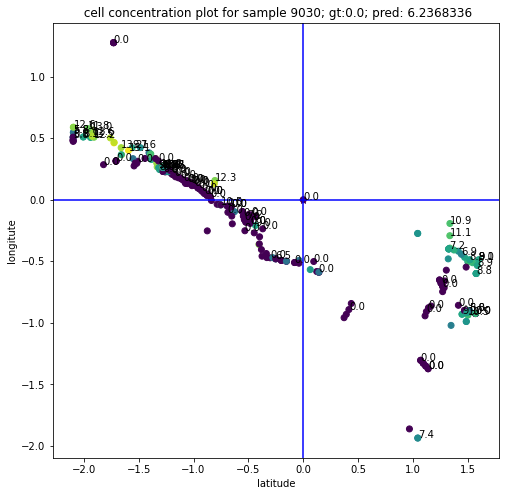

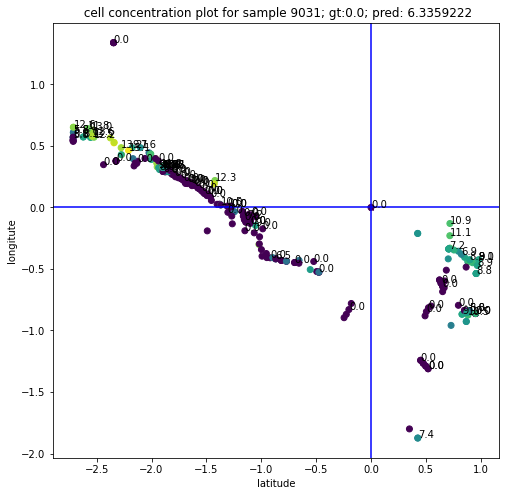

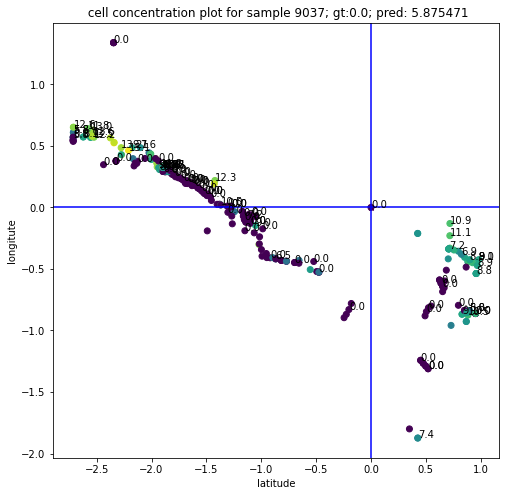

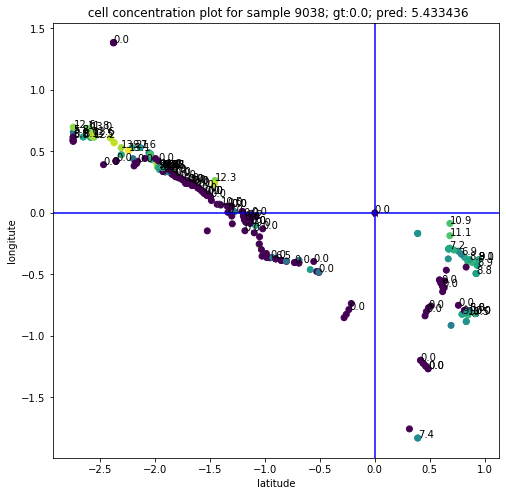

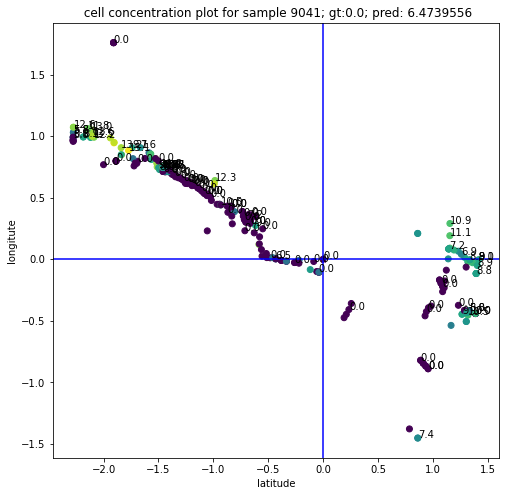

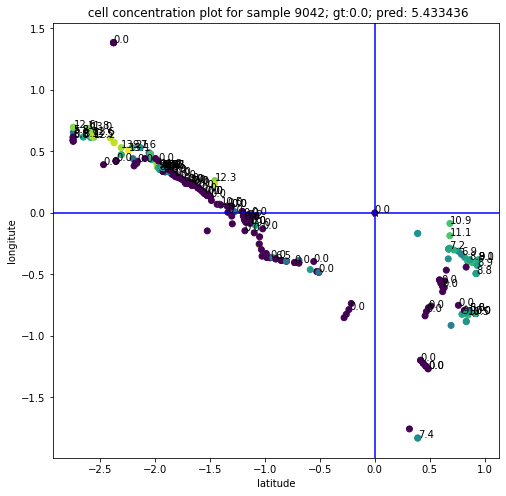

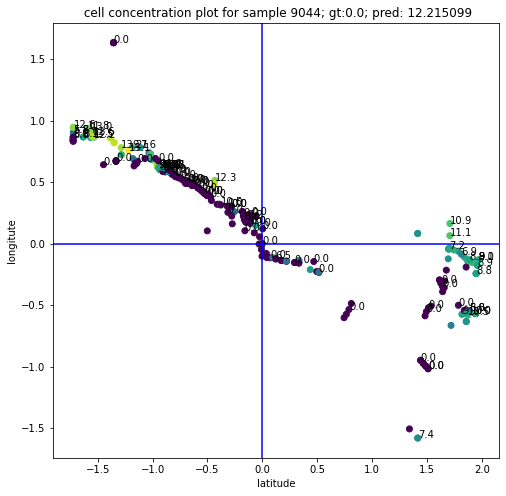

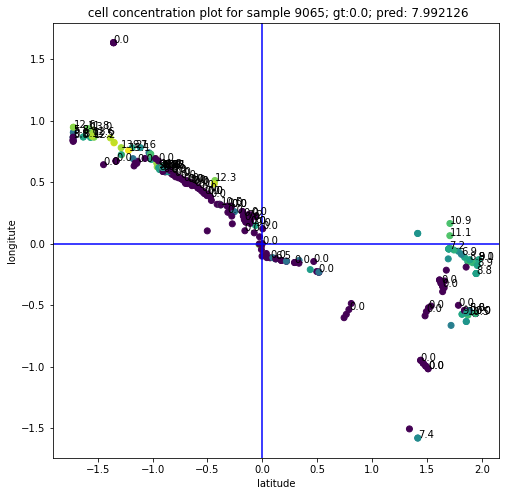

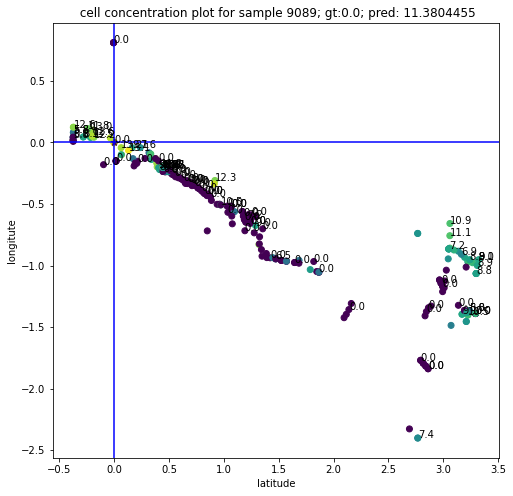

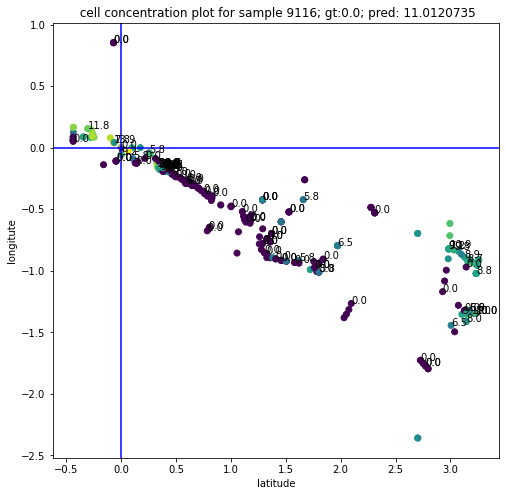

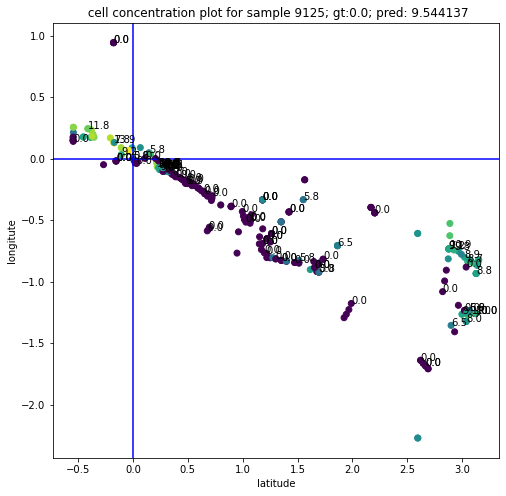

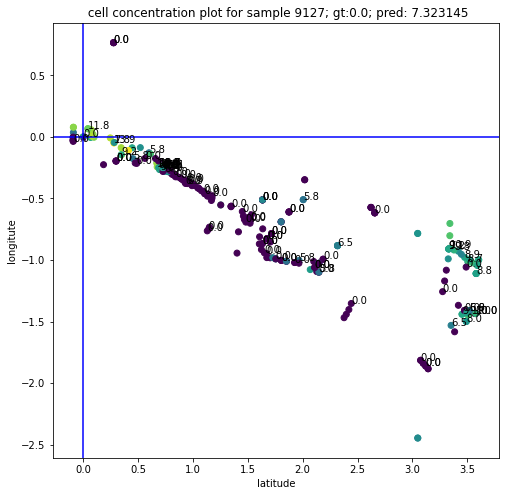

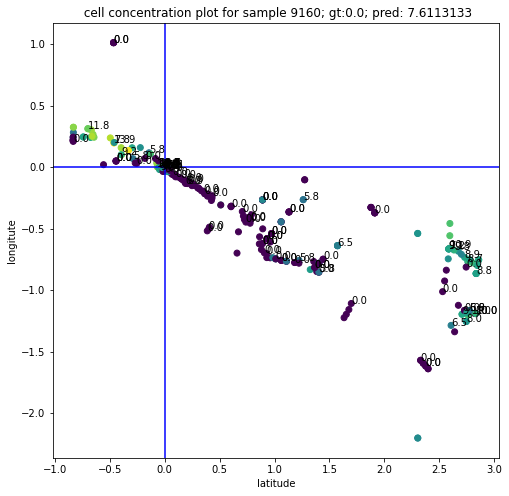

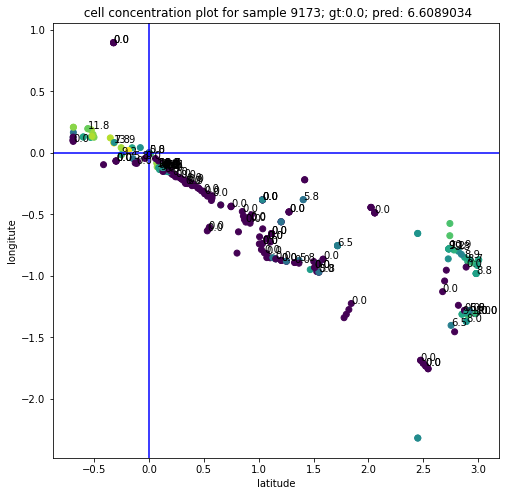

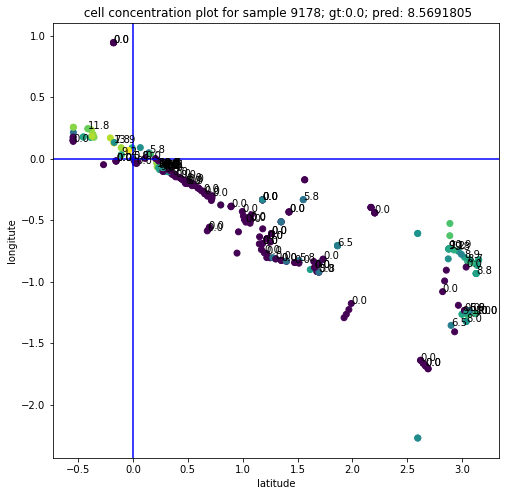

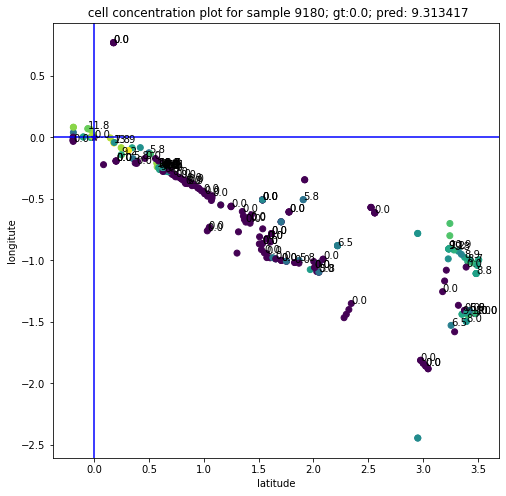

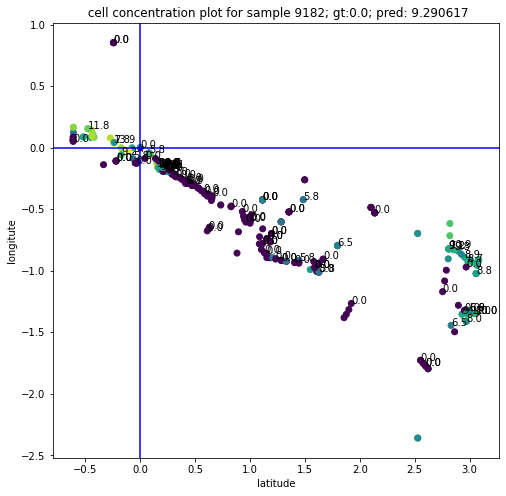

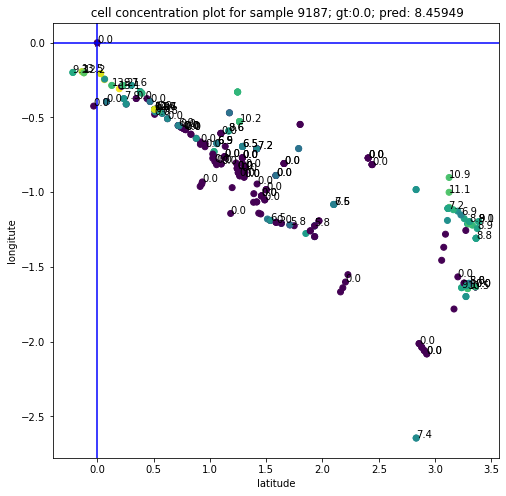

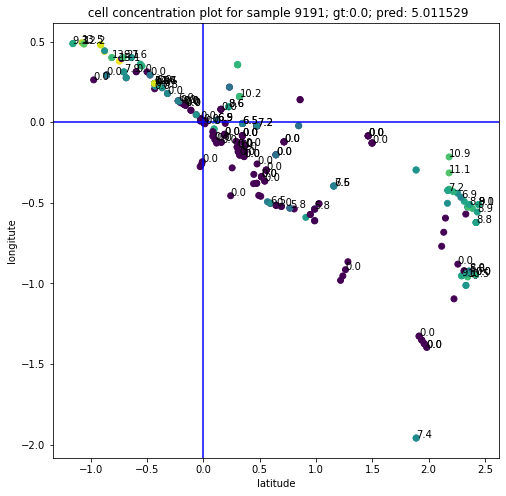

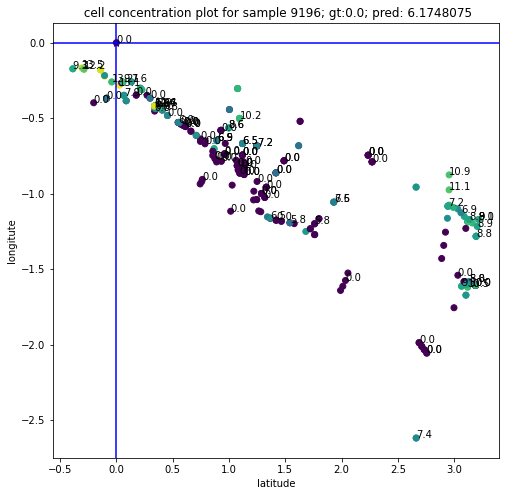

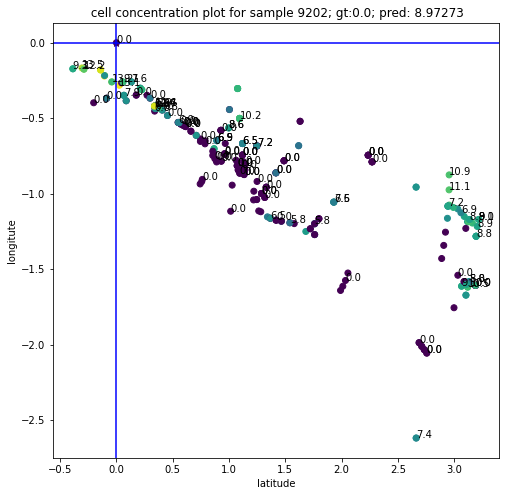

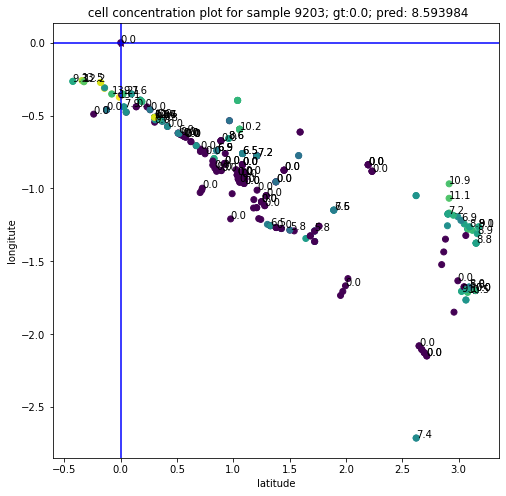

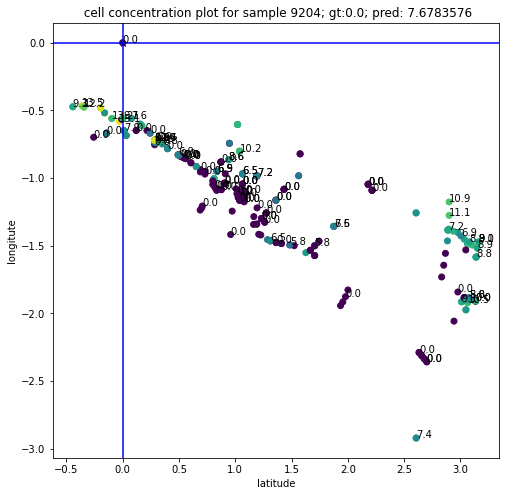

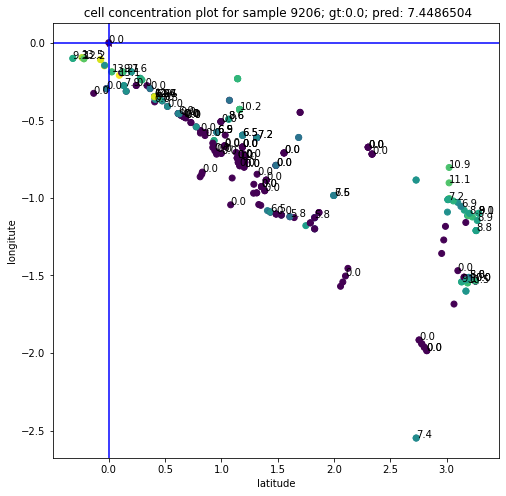

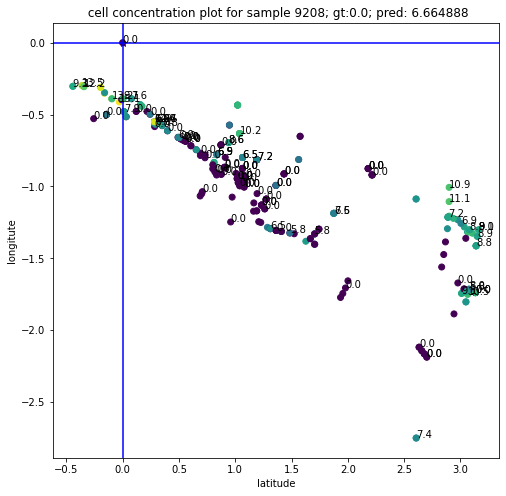

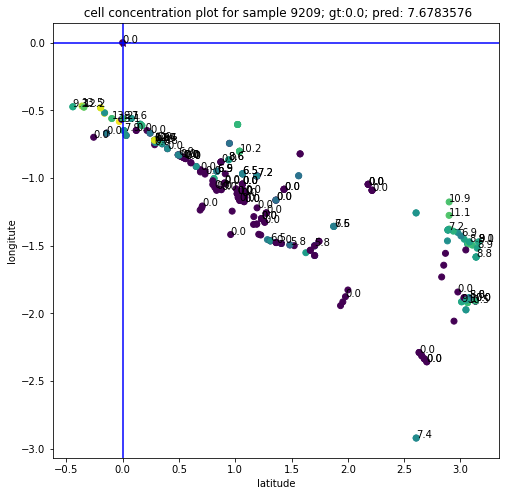

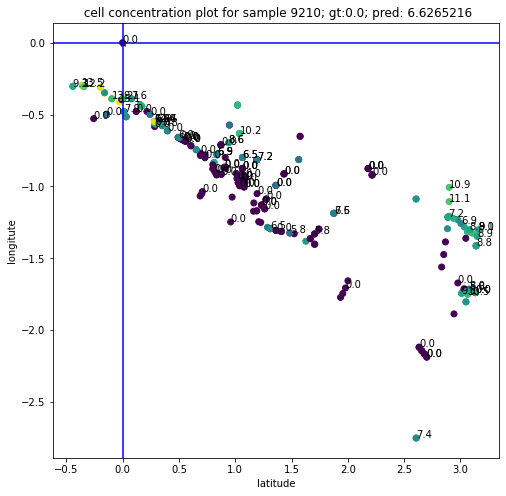

In [272]:
import matplotlib.cm as cm

start = 1660
end = 1700
time_plot = test_input_time.cpu().detach().numpy() ### 20041*301*1
space_plot = test_input_space.cpu().detach().numpy()### 20041*301*2
concen_plot = test_input_seq[:,:,-1].cpu().detach().numpy()### 20041*301
pred_plot = prediction.flatten()
desire_len = 1
for i in result[start:end]:
    if(test_label[i] <= 5):
        sample = i
        print("sample : ", i ,"test label", test_label[i])
        #space = space_plot[i] - space_plot[(i - TIME_WINDOW):(i+1)]
#         space_norm = np.zeros(TIME_WINDOW + 1)
#         space_norm = np.sqrt(space[:, 0]**2 + space[:, 1]**2)
        space = space_plot[i,0,:] - space_plot[i,0:,:]
        #space_norm = np.zeros(TIME_WINDOW)
        space_norm_xaxis = space[:, 0]
        space_norm_yaxis = space[:, 1]
        #print(space_norm.shape)
        #time = time_plot[i] - time_plot[(i - TIME_WINDOW):(i+1)]
        #print(time.shape)
        time = time_plot[i,0] - time_plot[i,0:]
        ###weight_plot = np.copy(weight[i])
        #label_plot = np.copy(eval_label[(i - TIME_WINDOW):(i+1)])
        label_plot = np.copy(concen_plot[i, 0:])
        label_plot = np.round(label_plot, decimals = 1)
        ###weight_plot = np.round(weight_plot, decimals = 3)
#         print("time: ", time)
#         #print("space", space)
#         print("label", label_plot)
        fig = plt.figure(figsize=(8, 8))
        #ax = fig.add_subplot(projection='3d')
        ax = fig.add_subplot()
        ax.scatter(space_norm_xaxis, space_norm_yaxis, c = label_plot)
        ax.scatter(0,0, marker="*",c=10, s = 50)
        plt.axvline(x = 0, color = 'b')
        plt.axhline(y = 0, color = 'b')

        ax.set_xlabel('latitude')
        ax.set_ylabel('longitute')
        plt.title(' cell concentration plot for sample ' + str(sample)+ '; gt:' + str(label_plot[0]) + "; pred: " + 
                 str(pred_plot[i]))
        
        k = 0
        space_norm_copy = space_norm_xaxis[::3]
        time_copy  = space_norm_yaxis[::3]
        for i,j in zip(space_norm_copy, time_copy):
#             ax.annotate(str(weight_plot[k]),xy=(i,j))
#             for a,b in zip(x, y): 
            plt.text(i, j, str(label_plot[k]))
            k = k + 3
        
#         print("weight: ", weight_plot)
#         fig = plt.figure(figsize=(8, 8))
#         ax = fig.add_subplot()
#         ax.scatter(space_norm_xaxis, space_norm_yaxis, c = weight_plot)
#         ax.set_xlabel('latitude')
#         ax.set_ylabel('longitute')
#         plt.title('neighbor weight plot sample '  + str(sample))
        
#         k = 0
#         space_norm_copy = space_norm_xaxis[::3]
#         time_copy  = space_norm_yaxis[::3]
#         for i,j in zip(space_norm_copy, time_copy):
#             plt.text(i, j, str(weight_plot[k]))
#             k = k + 3

  

In [18]:
train_instance = train_input_seq.shape[0]

num_batch = math.ceil(train_input_seq.shape[0] / BATCH_SIZE)
#BATCH_SIZE = 32
batch_train_downsample = []

for k in range(num_batch):
    s_idx = k * BATCH_SIZE

    e_idx = min(train_instance, s_idx + BATCH_SIZE)

    new_row = []
    new_col = []
    new_data = []
    i  = 0
    for train_downsample_sub in train_downsample[s_idx:e_idx]:
        train_downsample_sub = train_downsample_sub.tocoo()
        new_row = np.concatenate((new_row,longest_window*i + train_downsample_sub.row), axis = 0)
        new_col = np.concatenate((new_col,(TIME_WINDOW+1)*i + train_downsample_sub.col), axis = 0)
        new_data = np.concatenate((new_data, train_downsample_sub.data), axis=0)
        i = i + 1
    indices = torch.cat((torch.tensor(new_row[np.newaxis,:], dtype = torch.int), torch.tensor(new_col[np.newaxis,:],  dtype = torch.int)), axis = 0)
    values = torch.tensor(new_data)
    batch_train_downsample.append(torch.sparse_coo_tensor(indices, values, [longest_window*(i), (TIME_WINDOW+1)*(i)],
                                                          dtype = torch.double,device=device))
            
        

In [19]:
# def generateTrainDataset(train_input_seq,train_input_time,train_input_space, train_new_features_data,train_src_mask,batch_train_downsample):
#     train_batch_sample = []
#     for k in range(num_batch):
#         s_idx = k * BATCH_SIZE

#         e_idx = min(train_instance, s_idx + BATCH_SIZE)
#         #feat_cut = torch.clone(train_data[s_idx:e_idx])
#         #feat_cut[:,0, features.shape[1]-1] = 0
#         for loop in np.random.randint(low=0, high = TIME_WINDOW, size =(number_selection,)):
            
#             label_cut = torch.clone(train_input_seq[s_idx:e_idx, loop, -1])
#             train_input_cut = torch.clone(train_input_seq[s_idx:e_idx])
#             train_input_cut[:, loop, -1] = 0
            
#             train_output_cut =  torch.clone(train_input_cut[:, loop,:]).unsqueeze(1)
            
            
#             #train_output_cut[:, 0, -1] = 0
#             train_output_time_cut = train_new_features_data[s_idx:e_idx,loop, -1].unsqueeze(1)
#             train_output_space_cut = train_new_features_data[s_idx:e_idx,loop, -3:-1].unsqueeze(1)
#             train_trg_mask_cut = [[train_mask[i][loop]] for i in range(s_idx, e_idx)] #train_src_mask[s_idx:e_idx, loop,:].unsqueeze(1)
            
#             train_batch_sample.append([train_input_cut, train_output_cut, batch_train_downsample[k],
#                                   train_input_time[s_idx:e_idx], train_input_space[s_idx:e_idx],train_output_time_cut, 
#                                   train_output_space_cut,train_src_mask[s_idx:e_idx],train_trg_mask_cut, label_cut])



# train_upsample_data = generateTrainDataset(train_input_seq,train_input_time,train_input_space, train_new_features_data,train_src_mask,batch_train_downsample)
        
            
        

In [20]:
def generateTrainDataset(train_input_seq,train_input_time,train_input_space, train_new_features_data,train_src_mask,batch_train_downsample,
                        num_batch,BATCH_SIZE,train_instance):
    train_batch_sample = []
    for k in range(num_batch):
        s_idx = k * BATCH_SIZE

        e_idx = min(train_instance, s_idx + BATCH_SIZE)
        #feat_cut = torch.clone(train_data[s_idx:e_idx])
        #feat_cut[:,0, features.shape[1]-1] = 0
        for loop in [0] + list(np.random.randint(low=0, high = TIME_WINDOW, size =(number_selection-1,))):
            
            label_cut = torch.clone(train_input_seq[s_idx:e_idx, loop, -1])
            train_input_cut = torch.clone(train_input_seq[s_idx:e_idx])
            train_input_cut[:, loop, -1] = 0
            
            train_output_cut =  torch.clone(train_input_cut[:, loop,:]).unsqueeze(1)
            
            
            #train_output_cut[:, 0, -1] = 0
            train_output_time_cut = train_new_features_data[s_idx:e_idx,loop, -1].unsqueeze(1)
            train_output_space_cut = train_new_features_data[s_idx:e_idx,loop, -3:-1].unsqueeze(1)
            train_trg_mask_cut = torch.IntTensor([[train_mask[i][loop]] for i in range(s_idx, e_idx)]).to(device)
            
            train_batch_sample.append([train_input_cut, train_output_cut, batch_train_downsample[k],
                                  train_input_time[s_idx:e_idx], train_input_space[s_idx:e_idx],train_output_time_cut, 
                                  train_output_space_cut,train_src_mask[s_idx:e_idx],train_trg_mask_cut, label_cut])
    return train_batch_sample



train_upsample_data = generateTrainDataset(train_input_seq,train_input_time,train_input_space, train_new_features_data,train_src_mask,batch_train_downsample, num_batch,BATCH_SIZE,train_instance)      

print("finished train upsample data")


finished train upsample data


In [66]:
evaluation_loss,prediction,weights = evaluate(transformer, val_input_seq, val_output_seq, val_downsample,
                              val_input_time, val_input_space,val_output_time, 
                              val_output_space,val_src_mask,val_trg_mask,
             BATCH_SIZE,lr_criterion)

In [22]:
pytorch_total_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)

For test

Train function

In [13]:
def shuffle_data_label(data, label):
    shuffler = np.random.permutation(len(label))
    data_shuffled = data[shuffler]
    label_shuffled = label[shuffler]
    return data_shuffled, label_shuffled

def train(transformer, train_data, train_label,n_epoch,BATCH_SIZE,lr_criterion,eval_range,Mpos, Vpos):
    training_loss = []
    validation_loss = []

    space_pe_weight = []
    time_pe_weight = []
    parm={}
    pre_valid_loss = 100
    num_batch = math.ceil(train_data.shape[0] / BATCH_SIZE)
    for epoch in (range(n_epoch)):
        train_data, train_label = shuffle_data_label(train_data, train_label)

        lr_pred_prob = np.zeros(train_data.shape[0])
        total_loss = 0
        
        for k in range(num_batch):
            s_idx = k * BATCH_SIZE

            e_idx = min(train_instance, s_idx + BATCH_SIZE)
            feat_cut = torch.clone(train_data[s_idx:e_idx])
            #feat_cut[:,0, features.shape[1]-1] = 0
            label_cut = train_label[s_idx:e_idx]

            lr_optimizer.zero_grad()
            transformer = transformer.train()

            lr_prob = transformer(feat_cut, label_cut,Mpos, Vpos)
            lr_loss = lr_criterion(lr_prob, 
                                   label_cut)

            lr_loss.backward()
            
            lr_prob = transformer(label_cut,feat_cut,Vpos ,Mpos)
            lr_loss = lr_criterion(lr_prob, 
                                   feat_cut)
            lr_loss.backward()
            
            lr_optimizer.step()
            
            
            
            total_loss += lr_loss
        scheduler.step(epoch = epoch)
        print('Epoch {}, lr {}'.format(epoch, lr_optimizer.param_groups[0]['lr']))
        for name, param in transformer.named_parameters():
            #print(name)
            #print("name: ", name, "param: ", param) # space_encoder.Wr.weight time_encoder.basis_freq
            if 'space_encoder.Wr.weight' in name:
                parm[name]=param.cpu().detach().numpy()  
                space_pe_weight.append(parm['space_encoder.Wr.weight'])
            if 'time_encoder.basis_freq' in name:
                #print(param)
                parm[name]=param.cpu().detach().numpy()
                time_pe_weight.append(parm['time_encoder.basis_freq'])        
        #scheduler.step()
                #torch.save(tgan.state_dict(), './saved_models/edge_{}_wkiki_node_class.pth'.format(DATA))

        print("epoch: ", epoch, "training loss: ", total_loss.cpu().detach().numpy() / train_instance)
        if epoch%eval_range == 0:
            evaluation_loss,prediction = evaluate(transformer, val_data,val_label,BATCH_SIZE, lr_criterion,Mpos = Mpos, Vpos=Vpos)
            #print("pred_prob: ", pred_prob)
            print("epoch: ", epoch, "validation loss: ",evaluation_loss)
            training_loss.append(lr_loss)
            validation_loss.append(evaluation_loss)
#         if test_loss > pre_valid_loss: 
#             path = "trained_model/tgan_space_iter_" + str(epoch) +"_" +str(np.round(f1_score.cpu().detach().numpy(),2))+ ".pt"
#             torch.save(transformer.state_dict(), path)
#         pre_valid_loss = test_loss
#     path = "trained_model/tgan_space_iter_" + str(epoch) +"_" +str(np.round(f1_score.cpu().detach().numpy(),2))+ ".pt"
#     torch.save(transformer.state_dict(), path)   

Start train and evaluate

In [ ]:
eval_range = 50
train(transformer, train_data, train_label,n_epoch=1000,BATCH_SIZE=256, lr_criterion = lr_criterion,eval_range = eval_range,Mpos = Mpos, Vpos=Vpos)

In [20]:

test_loss, test_prediction =  evaluate(transformer, test_data,test_label,BATCH_SIZE=256, lr_criterion = lr_criterion, Mpos = Mpos, Vpos=Vpos)
test_prediction = test_prediction*label_std.cpu().detach().numpy() + label_mean.cpu().detach().numpy()